In [1]:
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

In [3]:
def load_data(n_workers, batch_size, data, path):
  transform = transforms.ToTensor()
  
  if data == 'MNIST':
    train_data = datasets.MNIST(root=path, train=True, download=True, transform=transform)
  if data == 'FashionMNIST':
    train_data = datasets.FashionMNIST(root=path, train=True, download=True, transform=transform) 

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers = n_workers)

  return train_loader

In [4]:
def check_load_data(train_loader, start_ind, end_ind):
  dataiter = iter(train_loader)
  images, _ = dataiter.next()
  images = images.numpy()
  for i in (start_ind, end_ind, 1):
    img = np.squeeze(images[i])
    fig = plt.figure(figsize = (3,3)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')  

In [5]:
class Generator(nn.Module):
  def __init__(self, n_inputs, n_outputs, n_hiddens, n_drop, n_leakyRelu):
    super(Generator, self).__init__()

    self.n_inputs = n_inputs

    self.fc1 = nn.Linear(n_inputs, n_hiddens)
    self.fc2 = nn.Linear(n_hiddens, n_hiddens*2)
    self.fc3 = nn.Linear(n_hiddens*2, n_hiddens*4)
    self.fc4 = nn.Linear(n_hiddens*4, n_outputs)

    self.dropout = nn.Dropout(n_drop)
    self.tanh = nn.Tanh()
    self.leakyRelu = nn.LeakyReLU(n_leakyRelu)

  def forward(self, x):
    out = self.fc1(x)
    out = self.leakyRelu(out)
    out = self.dropout(out)

    out = self.fc2(out)
    out = self.leakyRelu(out)
    out = self.dropout(out)

    out = self.fc3(out)
    out = self.leakyRelu(out)
    out = self.dropout(out)

    out = self.fc4(out)
    out = self.tanh(out)

    return out

class Discriminator(nn.Module):
  def __init__(self, n_inputs, n_outputs, n_hiddens, n_drop, n_leakyRelu):
    super(Discriminator, self).__init__()

    self.fc1 = nn.Linear(n_inputs, n_hiddens*4)
    self.fc2 = nn.Linear(n_hiddens*4, n_hiddens*2)
    self.fc3 = nn.Linear(n_hiddens*2, n_hiddens)
    self.fc4 = nn.Linear(n_hiddens, n_outputs)

    self.dropout = nn.Dropout(n_drop)
    self.sigmoid = nn.Sigmoid()
    self.leakyRelu = nn.LeakyReLU(n_leakyRelu)

  def forward(self, x):
    x = x.view(-1, 28*28)

    out = self.fc1(x)
    out = self.leakyRelu(out)
    out = self.dropout(out)

    out = self.fc2(out)
    out = self.leakyRelu(out)
    out = self.dropout(out)

    out = self.fc3(out)
    out = self.leakyRelu(out)
    out = self.dropout(out)

    out = self.fc4(out)
    out = self.sigmoid(out)

    return out


In [15]:
def real_loss(x):
  labels = torch.ones(x.size(0))*0.9
  criterion = nn.BCELoss()
  return criterion(x.squeeze(), labels)

def fake_loss(x):
  labels = torch.zeros(x.size(0))
  criterion = nn.BCELoss()
  return criterion(x.squeeze(), labels)

In [16]:
import torch.optim as optim

def train_GAN(D, G, data, epochs = 100, learning_rate = 0.001):
  lr = learning_rate
  d_optimizer = optim.Adam(D.parameters(), lr)
  g_optimizer = optim.Adam(G.parameters(), lr)

  losses = []

  fixed_z = np.random.uniform(-1, 1, size=G.n_inputs)
  fixed_z = torch.from_numpy(fixed_z).float()
  check_img = []
  
  D.train()
  G.train()
  for epoch in range(epochs):
    d_loss_per_epoch = 0
    g_loss_per_epoch = 0
    for i, (img, _) in enumerate(data):
      batch_size = img.size(0)
      img = img*2 -1
      for j in range(1):
        d_optimizer.zero_grad()
        d_real_train = D(img)
        d_real_loss = real_loss(d_real_train)

        with torch.no_grad():
          z = np.random.uniform(-1, 1, size=(batch_size, G.n_inputs))
          z = torch.from_numpy(z).float()
          fake_img = G(z)
                      
        d_fake_train = D(fake_img)
        d_fake_loss = fake_loss(d_fake_train)
                  
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

      g_optimizer.zero_grad()
      z = np.random.uniform(-1, 1, size=(batch_size, G.n_inputs))
      z = torch.from_numpy(z).float()
      fake_img = G(z)

      g_train = D(fake_img)
      g_loss = real_loss(g_train)
      g_loss.backward()
      g_optimizer.step()
      d_loss_per_epoch += d_loss
      g_loss_per_epoch += g_loss

    d_loss_per_epoch /= len(data)
    g_loss_per_epoch /= len(data)
    print('Epoch:', epoch + 1,"| d_loss:", d_loss_per_epoch.item(), "| g_loss:", g_loss_per_epoch.item())
    losses.append((d_loss_per_epoch, g_loss_per_epoch))
    
    if epoch % 2: 
      with torch.no_grad():
        fake_img = G(fixed_z)
        check_img.append(fake_img)
  
  return losses, check_img


In [17]:
def show_gan_loss(loss):
  fig, ax = plt.subplots()
  d_losses = np.array(loss)
  g_losses = np.array(loss)
  plt.plot(d_losses, label='Discriminator')
  plt.plot(g_losses, label='Generator')
  plt.title("Training Losses")
  plt.legend()

In [18]:
def show_sample(G):
  z = np.random.uniform(-1, 1, G.n_inputs)
  z = torch.from_numpy(z).float()

  fake_img = G(z)

  fake_img = fake_img.detach().reshape((28,28))
  fig = plt.figure(figsize = (3,3)) 
  ax = fig.add_subplot(111)
  ax.imshow(fake_img, cmap='gray')  


In [19]:
def show_interpolation(inters):
  for i in inters:
    i = i.detach().reshape((28,28))
    fig = plt.figure(figsize = (3,3)) 
    ax = fig.add_subplot(111)
    ax.imshow(i, cmap='gray')  

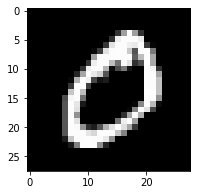

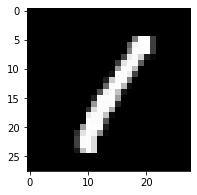

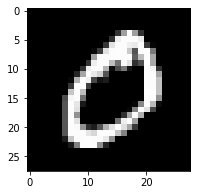

In [20]:
MNIST_data = load_data(0, 64, 'MNIST', 'mnist')
check_load_data(MNIST_data, 1, 3)

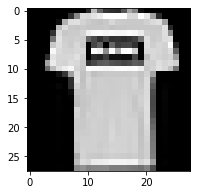

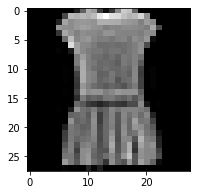

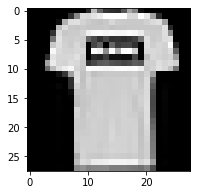

In [21]:
FashionMNIST_data = load_data(0, 64, 'FashionMNIST', 'fashion_mnist')
check_load_data(FashionMNIST_data, 1, 3)

In [22]:
g_input = 100
g_output = 784
g_hidden = 32
g_drop = 0.3
g_leakyRelu = 0.2
d_output = 1

G = Generator(g_input, g_output, g_hidden, g_drop, g_leakyRelu)
D = Discriminator(g_output, d_output, g_hidden, g_drop, g_leakyRelu)

print(G)
print(D)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
  (leakyRelu): LeakyReLU(negative_slope=0.2)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
  (leakyRelu): LeakyReLU(negative_slope=0.2)
)


In [23]:
mnist_gan_losses, minist_gan_inters = train_GAN(D, G, MNIST_data)

Epoch: 1 | d_loss: 0.8152907490730286 | g_loss: 2.9682202339172363
Epoch: 2 | d_loss: 0.8591644167900085 | g_loss: 2.2074923515319824
Epoch: 3 | d_loss: 0.8653585910797119 | g_loss: 2.0834197998046875
Epoch: 4 | d_loss: 0.9859198927879333 | g_loss: 1.6301555633544922
Epoch: 5 | d_loss: 1.0461193323135376 | g_loss: 1.491887092590332
Epoch: 6 | d_loss: 1.106001615524292 | g_loss: 1.323494791984558
Epoch: 7 | d_loss: 1.1454960107803345 | g_loss: 1.2147136926651
Epoch: 8 | d_loss: 1.1633082628250122 | g_loss: 1.164018988609314
Epoch: 9 | d_loss: 1.2027897834777832 | g_loss: 1.1142640113830566
Epoch: 10 | d_loss: 1.1866707801818848 | g_loss: 1.1272908449172974
Epoch: 11 | d_loss: 1.2122119665145874 | g_loss: 1.0968295335769653
Epoch: 12 | d_loss: 1.2007821798324585 | g_loss: 1.1111867427825928
Epoch: 13 | d_loss: 1.2096730470657349 | g_loss: 1.0862501859664917
Epoch: 14 | d_loss: 1.2295725345611572 | g_loss: 1.0553617477416992
Epoch: 15 | d_loss: 1.2323102951049805 | g_loss: 1.0489530563354

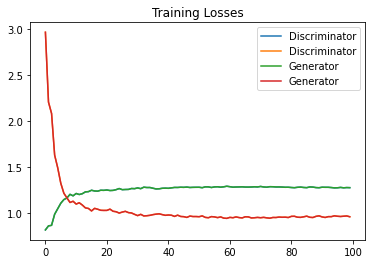

In [24]:
show_gan_loss(mnist_gan_losses)

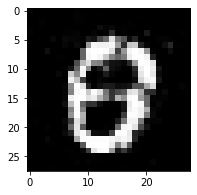

In [25]:
show_sample(G)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


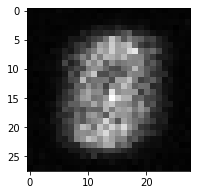

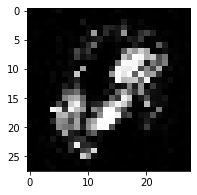

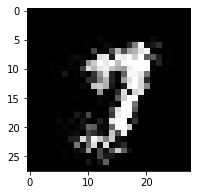

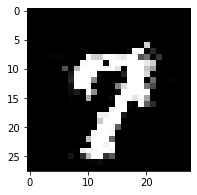

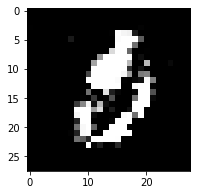

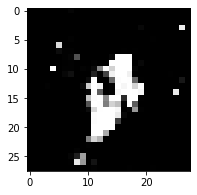

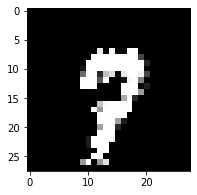

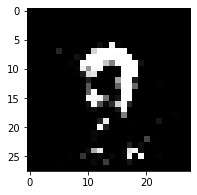

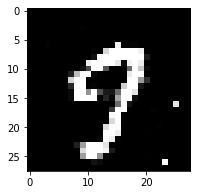

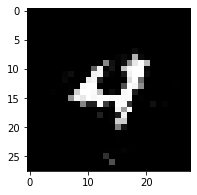

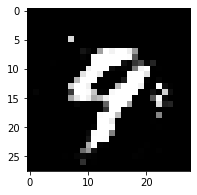

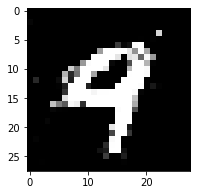

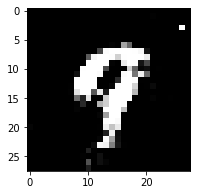

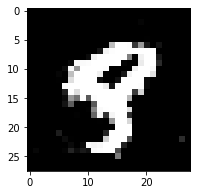

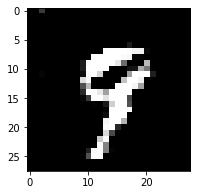

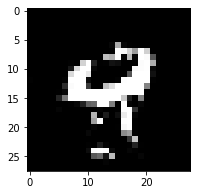

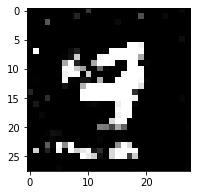

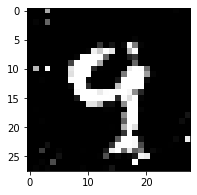

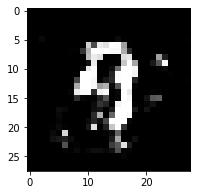

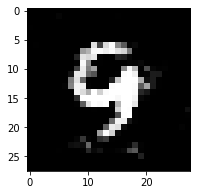

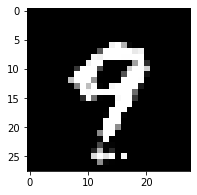

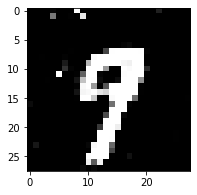

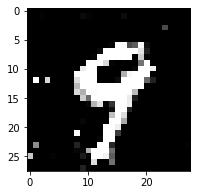

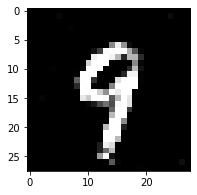

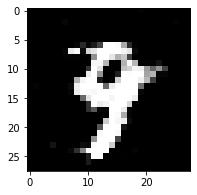

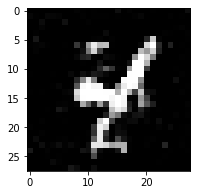

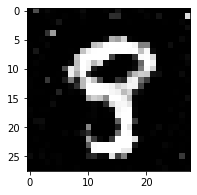

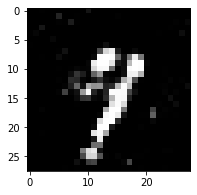

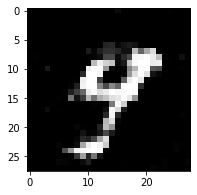

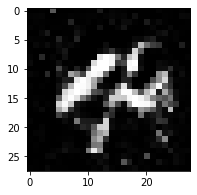

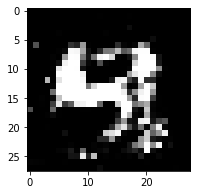

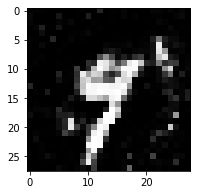

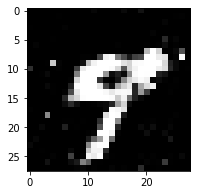

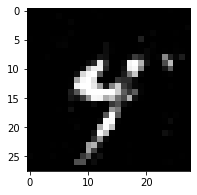

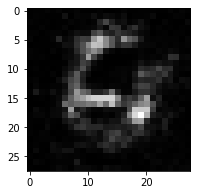

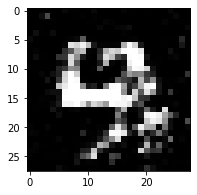

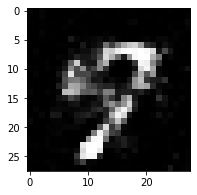

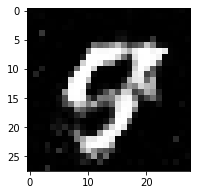

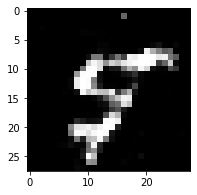

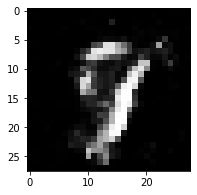

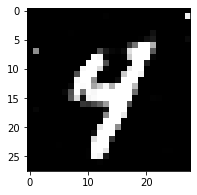

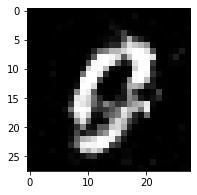

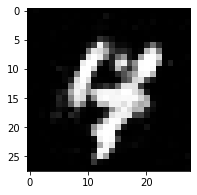

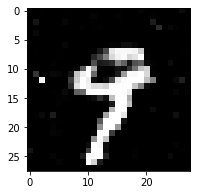

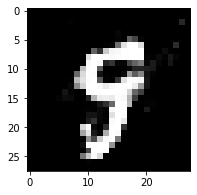

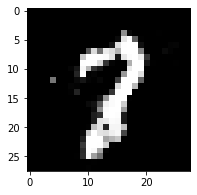

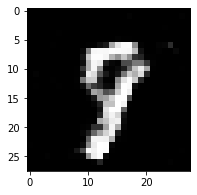

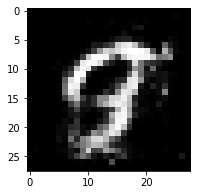

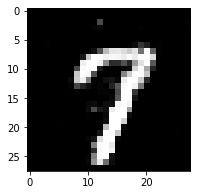

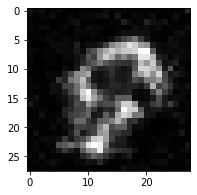

In [26]:
show_interpolation(minist_gan_inters)

In [27]:
Gf = Generator(g_input, g_output, g_hidden, g_drop, g_leakyRelu)
Df = Discriminator(g_output, d_output, g_hidden, g_drop, g_leakyRelu)
fashion_mnist_gan_losses, fashion_minist_gan_inters = train_GAN(Df, Gf, FashionMNIST_data)

Epoch: 1 | d_loss: 0.6088482737541199 | g_loss: 3.774561882019043
Epoch: 2 | d_loss: 0.7661145329475403 | g_loss: 2.878561019897461
Epoch: 3 | d_loss: 0.841369092464447 | g_loss: 2.4031009674072266
Epoch: 4 | d_loss: 1.0006966590881348 | g_loss: 1.6907494068145752
Epoch: 5 | d_loss: 1.0369173288345337 | g_loss: 1.5351800918579102
Epoch: 6 | d_loss: 1.1163361072540283 | g_loss: 1.3188953399658203
Epoch: 7 | d_loss: 1.1794170141220093 | g_loss: 1.2058814764022827
Epoch: 8 | d_loss: 1.1923959255218506 | g_loss: 1.1655603647232056
Epoch: 9 | d_loss: 1.2063630819320679 | g_loss: 1.146349549293518
Epoch: 10 | d_loss: 1.2295098304748535 | g_loss: 1.1038942337036133
Epoch: 11 | d_loss: 1.2217174768447876 | g_loss: 1.132299780845642
Epoch: 12 | d_loss: 1.2107529640197754 | g_loss: 1.1351693868637085
Epoch: 13 | d_loss: 1.2271614074707031 | g_loss: 1.1037158966064453
Epoch: 14 | d_loss: 1.249883770942688 | g_loss: 1.060741662979126
Epoch: 15 | d_loss: 1.255387544631958 | g_loss: 1.05178332328796

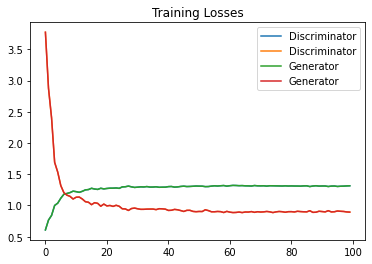

In [28]:
show_gan_loss(fashion_mnist_gan_losses)

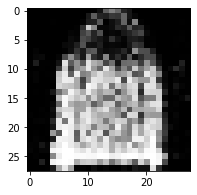

In [44]:
show_sample(Gf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


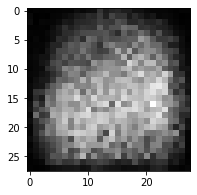

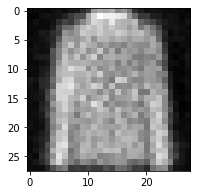

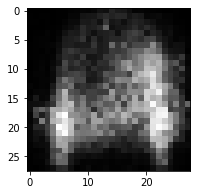

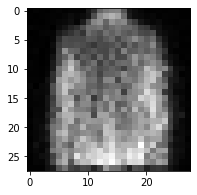

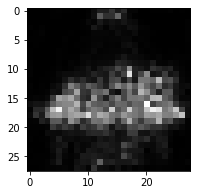

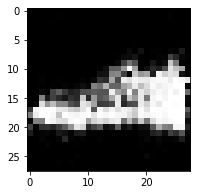

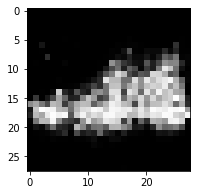

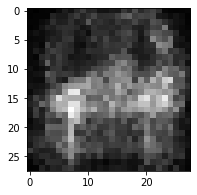

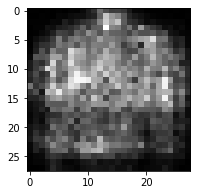

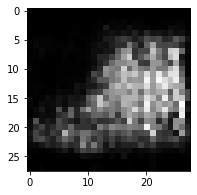

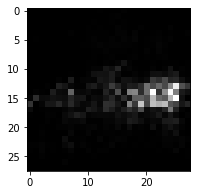

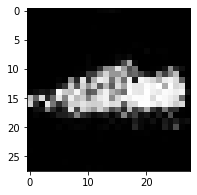

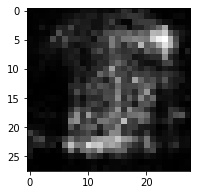

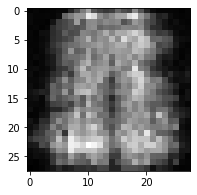

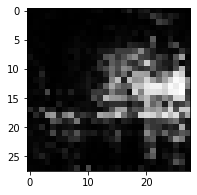

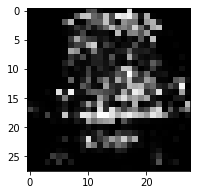

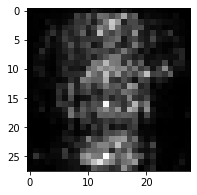

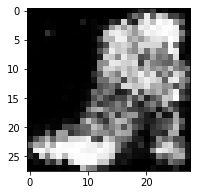

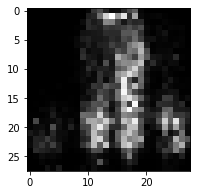

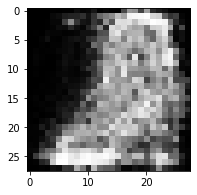

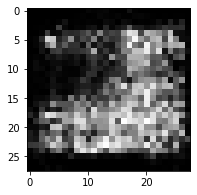

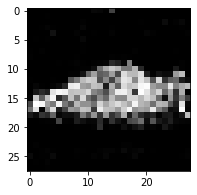

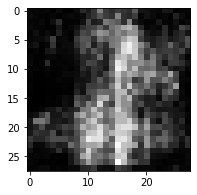

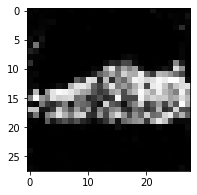

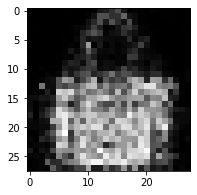

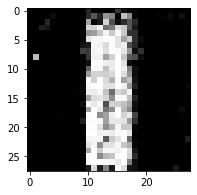

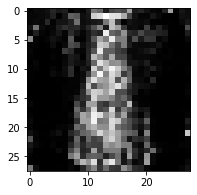

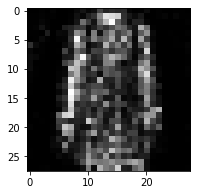

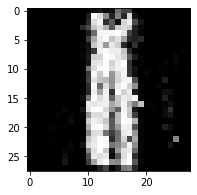

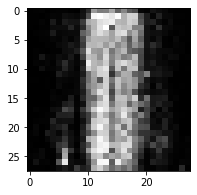

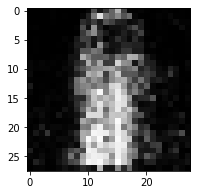

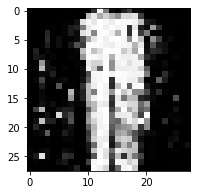

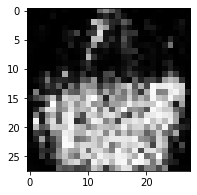

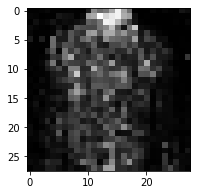

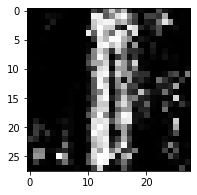

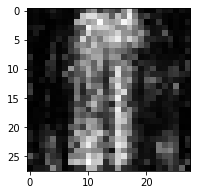

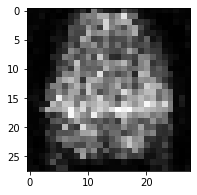

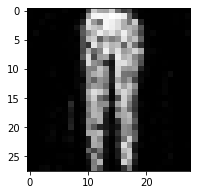

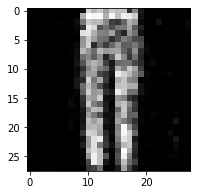

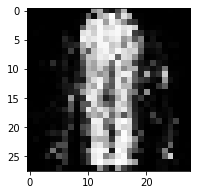

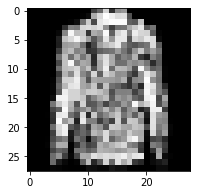

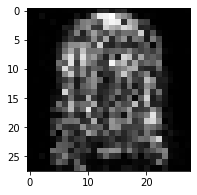

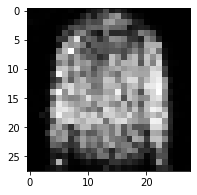

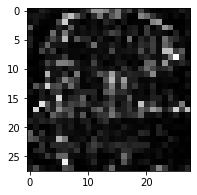

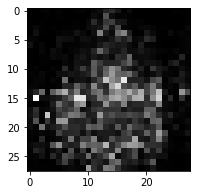

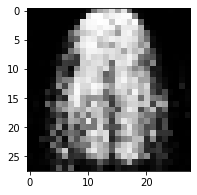

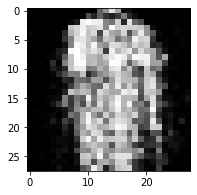

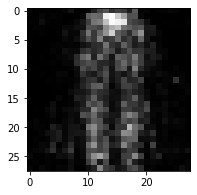

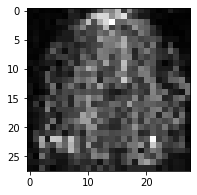

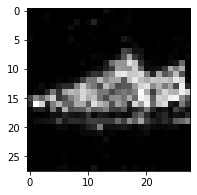

In [30]:
show_interpolation(fashion_minist_gan_inters)